In [32]:
%config IPCompleter.greedy=True
%matplotlib inline
saved_models_path = r"saved_models/"

## Libraries

In [33]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from pprint import pprint

import joblib

## Helper Functions

In [34]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

In [35]:
def create_classifier(clf, parameters, display_score=True, show_matrix=True, save=True):
    skfold = model_selection.StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=seed)

    for scorer in test_scoring:
        GS = GridSearchCV(clf, parameters, cv=skfold, scoring=scorer, n_jobs=cores,)
        GS.fit(X_train, y_train)
        if save:
            save_model(GS.best_estimator_, clf, scorer)
            
        print(f"{scorer} {GS.best_params_}\n\t{GS.best_score_}")
        if scorer == main_scorer:
            best_clf = GS.best_estimator_

    cv_results = model_selection.cross_validate(best_clf, X_test, y_test, cv=skfold, scoring=scoring, n_jobs=cores)
    
    new_models.append(best_clf)
    new_results.append(cv_results)
    
    if display_score:
        show_scores(cv_results)
    if show_matrix:
        plot_matrix(best_clf, X_test, y_test)
    
    return best_clf

In [36]:
def save_model(best_clf, clf, scorer):
    try:
        filename = saved_models_path + str(clf).rstrip("()") + "-" + scorer + ".joblib"
        print(filename)
        joblib.dump(best_clf, filename)
    except Exception as e:
        print(e)

In [37]:
def show_scores(result):
    for k, v in result.items():
        if k == 'fit_time' or k == 'score_time':
            continue
        else:
            print(f"{k:20} \t{v.mean():.4f}\t{v.std():>.8f} ")
    print()

In [38]:
def plot_matrix(clf, X_test, y_test, show_print=False):
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,6))

    titles_options = [("Confusion matrix, without normalization", None, ax1),
                    ("Normalized confusion matrix", 'true', ax2)]
    for title, normalize, ax in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test,
                                    cmap=plt.cm.Blues,
                                    normalize=normalize,
                                    ax=ax)
        disp.ax_.set_title(title)
        if show_print:
            print(title)
            print(disp.confusion_matrix)
    plt.draw()

# Data

## Data Set Preparations

In [39]:
df = pd.read_csv("outputs\songs.csv")
df.rename(columns={'Unnamed: 0': 'station_index'}, inplace=True)

df_X = df.iloc[:, 3:16]
df_y = df.liked

X = np.array(df.iloc[:, 3:16])
y = np.array(df.liked)

print(list(df_X.columns))
print(X.shape)

['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']
(2769, 13)


In [40]:
df.head()

,station_index,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,liked
0,0,I Don't Wanna Love You Anymore,LANY,0.702,0.623,0,-8.360,1,0.0417,0.3220,0.000000,0.0858,0.503,104.974,201198,4,1
1,1937,Beautiful Disaster,Jon McLaughlin,0.432,0.664,7,-4.662,1,0.0302,0.2150,0.000000,0.1500,0.294,156.216,251640,4,1
2,1925,Gone Too Soon,Simple Plan,0.204,0.811,2,-4.326,1,0.0313,0.0119,0.000000,0.0908,0.296,87.903,195547,4,1
3,1930,Your Guardian Angel,The Red Jumpsuit Apparatus,0.290,0.480,5,-6.583,1,0.0296,0.1160,0.000003,0.6260,0.382,112.620,229235,4,1
4,1931,Fall For Anything,The Script,0.558,0.842,10,-4.381,0,0.0340,0.1170,0.000000,0.0672,0.491,123.048,272773,4,1


In [41]:
df_X.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0.702,0.623,0,-8.360,1,0.0417,0.3220,0.000000,0.0858,0.503,104.974,201198,4
1,0.432,0.664,7,-4.662,1,0.0302,0.2150,0.000000,0.1500,0.294,156.216,251640,4
2,0.204,0.811,2,-4.326,1,0.0313,0.0119,0.000000,0.0908,0.296,87.903,195547,4
3,0.290,0.480,5,-6.583,1,0.0296,0.1160,0.000003,0.6260,0.382,112.620,229235,4
4,0.558,0.842,10,-4.381,0,0.0340,0.1170,0.000000,0.0672,0.491,123.048,272773,4


In [42]:
df_X.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000,2769.000000
mean,0.602809,0.690871,5.237631,-6.076351,0.682196,0.078640,0.196182,0.058485,0.193433,0.510321,122.251697,219589.224269,3.966053
std,0.139289,0.197969,3.591076,3.194620,0.465707,0.077134,0.263128,0.203739,0.157193,0.227006,29.179527,45944.105725,0.263925
min,0.000000,0.004840,0.000000,-35.068000,0.000000,0.000000,0.000004,0.000000,0.000000,0.000000,0.000000,4366.000000,0.000000
25%,0.514000,0.571000,2.000000,-7.051000,0.000000,0.036300,0.013000,0.000000,0.095000,0.335000,98.072000,195547.000000,4.000000
50%,0.612000,0.731000,5.000000,-5.382000,1.000000,0.050800,0.073100,0.000000,0.130000,0.508000,120.971000,214648.000000,4.000000
75%,0.700000,0.845000,8.000000,-4.154000,1.000000,0.083500,0.264000,0.000046,0.253000,0.680000,140.060000,238027.000000,4.000000
max,0.967000,0.993000,11.000000,-0.005000,1.000000,0.967000,0.995000,0.979000,0.976000,0.975000,214.118000,850467.000000,5.000000


## Data Explorations

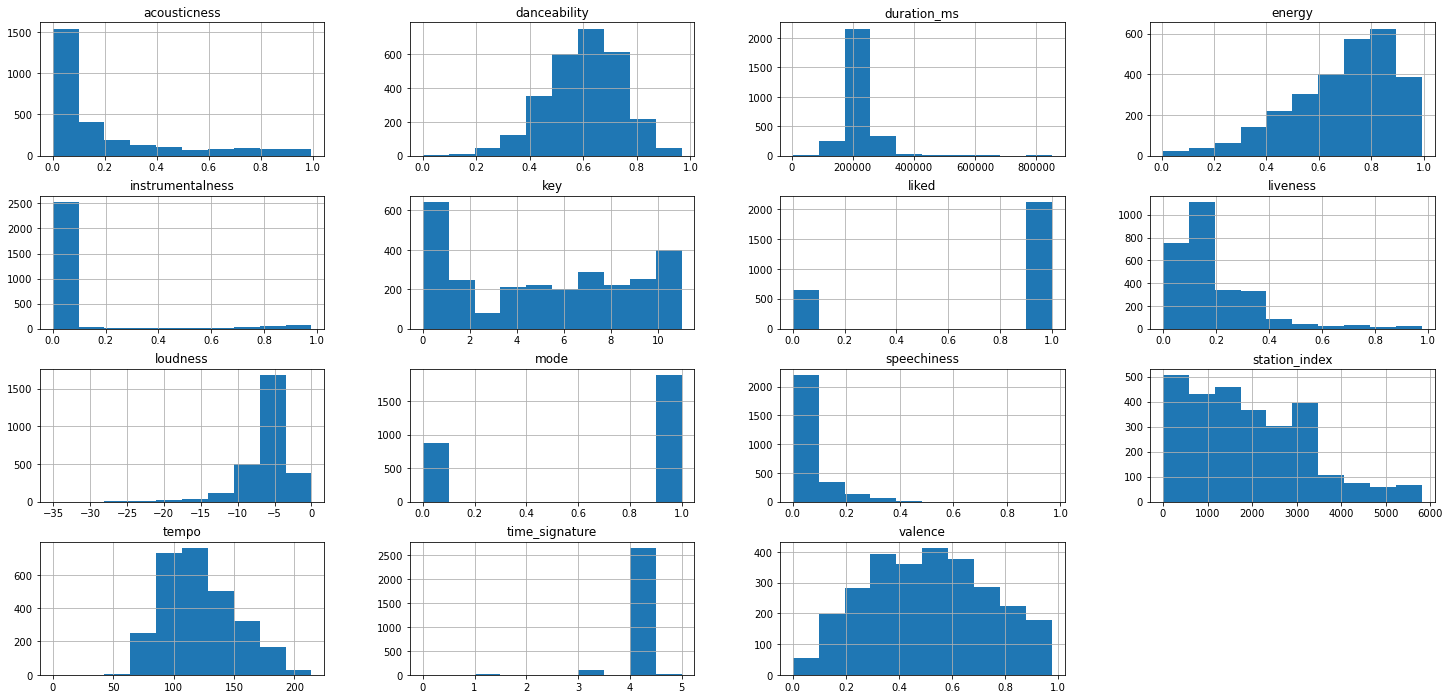

In [43]:
fig = plt.figure(figsize = (25,12))
ax = fig.gca()

df.hist(ax = ax)
plt.draw()

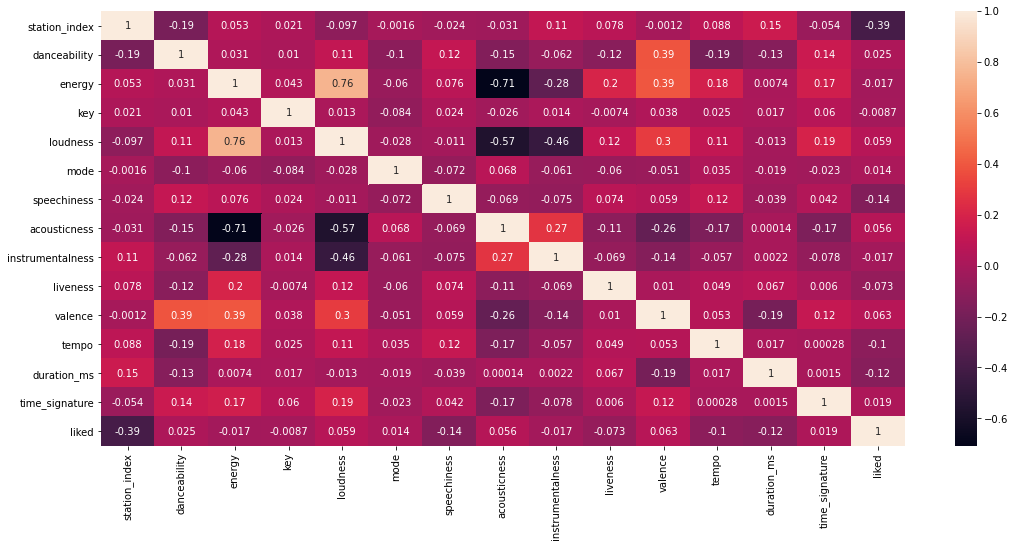

In [44]:
correlations = df.corr()
fig = plt.figure(figsize = (18,8))
sns.heatmap(correlations, xticklabels=correlations.columns, yticklabels=correlations.columns, annot=True)
plt.draw()

Trues: 0.7652582159624414 Falses: 0.2347417840375587


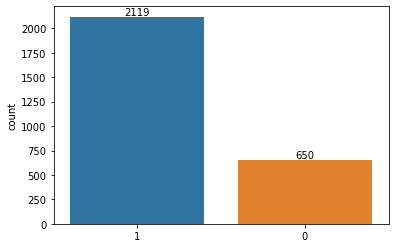

In [45]:
ax = sns.countplot(y, label="Sum", order=[1, 0])
values = df.liked.value_counts().values
value_total = values[0] + values[1]

for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 20, values[i], ha="center")
plt.draw()

print(f"Trues: {values[0]/value_total} Falses: {values[1]/value_total}")

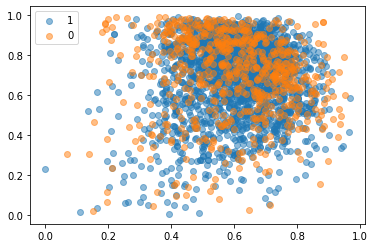

In [46]:
counter = Counter(y)
for label, _ in counter.items():
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], alpha=0.5, label=str(label))
plt.legend()
plt.draw()

# Feature Engineering

## Imports

In [47]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

## Feature Selection

In [48]:
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
min_max_scalar = MinMaxScaler()

standard_X = standard_scaler.fit_transform(df_X)
robust_X = robust_scaler.fit_transform(df_X)
min_max_X = min_max_scalar.fit_transform(df_X)

In [49]:
sel = VarianceThreshold(threshold=.1)
sel.fit(df_X)
sel_X = sel.transform(df_X)

cols_indices = [(col, index) for col, index in zip(df_X.columns, sel.get_support()) if index == True]
pprint(cols_indices)

[('key', True),
 ('loudness', True),
 ('mode', True),
 ('tempo', True),
 ('duration_ms', True)]


In [50]:
df_columns = pd.DataFrame(df_X.columns)

In [51]:
dependency = [f_classif, mutual_info_classif]
scalers = [df_X, standard_X, robust_X, min_max_X]

feature_scores = []
for scale in scalers:
    for test in dependency:
        best_features = SelectKBest(score_func=test, k='all')

        fit = best_features.fit(scale, df_y)

        feature_results = pd.DataFrame(fit.scores_)
        feature_results = pd.concat([df_columns, feature_results], axis=1)
        feature_results.columns = ['Features', 'Score']
        feature_results.sort_values(['Score'], inplace=True, ascending=False)
        feature_scores.append(feature_results)

In [52]:
scale_name  = ['df_X', 'standard_X', 'robust_X', 'min_max_X']
dependency_name = [f"{name}: [{scale}]" for scale in scale_name for name in ["F", "MI"] ]

display_side_by_side(feature_scores, dependency_name)

,Features,Score
5,speechiness,56.858382
11,duration_ms,43.178999
10,tempo,30.440568
8,liveness,14.882412
9,valence,11.134631
3,loudness,9.825199
6,acousticness,8.722136
0,danceability,1.750758
12,time_signature,1.016377
1,energy,0.809717


# Modeling

## Imports

In [117]:
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC


## Configuration

In [54]:
seed = 8
k_splits = 13
scoring = ['accuracy', 'balanced_accuracy', 'precision', 'recall' , 'f1', 'average_precision', 'roc_auc']
test_scoring = ['balanced_accuracy', 'f1', 'average_precision', 'roc_auc']
main_scorer = 'balanced_accuracy'
cores = -1

## Base Models

In [55]:
base_models = []
base_models.append(DecisionTreeClassifier())
base_models.append(GaussianNB())
base_models.append(KNeighborsClassifier())
base_models.append(LinearDiscriminantAnalysis())
base_models.append(LogisticRegression())
base_models.append(QuadraticDiscriminantAnalysis())
base_models.append(SVC())

In [56]:
X_base = X
y_base = y

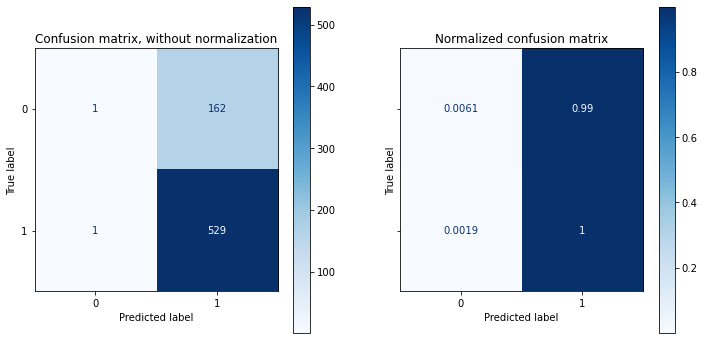

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_base, y, random_state=seed, shuffle=True, stratify=y)

clf = SVC()
clf.fit(X_train, y_train)

plot_matrix(clf, X_test, y_test)

In [58]:
base_results = []

for model in base_models:
    skfold = model_selection.StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=seed)
    cv_results = model_selection.cross_validate(model, X_base, y_base, cv=skfold, scoring=scoring, n_jobs=cores)
    base_results.append(cv_results)

In [59]:

for model, result in zip(base_models, base_results):
    print(f"{model}")
    print(f"Parameter\t\t Mean\t Std")
    show_scores(result)

DecisionTreeClassifier()
Parameter		 Mean	 Std
test_accuracy        	0.6717	0.02318065 
test_balanced_accuracy 	0.5615	0.03489693 
test_precision       	0.7953	0.01703807 
test_recall          	0.7692	0.02186170 
test_f1              	0.7819	0.01602025 
test_average_precision 	0.7894	0.01420306 
test_roc_auc         	0.5624	0.03630816 

GaussianNB()
Parameter		 Mean	 Std
test_accuracy        	0.7595	0.01575006 
test_balanced_accuracy 	0.5245	0.02254807 
test_precision       	0.7745	0.00862943 
test_recall          	0.9674	0.01451492 
test_f1              	0.8602	0.00941113 
test_average_precision 	0.8313	0.02069267 
test_roc_auc         	0.6245	0.03405881 

KNeighborsClassifier()
Parameter		 Mean	 Std
test_accuracy        	0.7288	0.02043561 
test_balanced_accuracy 	0.5231	0.02797397 
test_precision       	0.7745	0.01118118 
test_recall          	0.9108	0.02050548 
test_f1              	0.8371	0.01297046 
test_average_precision 	0.7823	0.01710763 
test_roc_auc         	0.5370	0.03706877

## New Models

In [60]:
new_models = []
new_results = []

X_train, X_test, y_train, y_test = train_test_split(min_max_X, y, random_state=seed, shuffle=True, stratify=y)

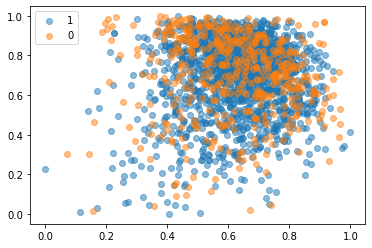

In [61]:
counter = Counter(y_train)
for label, _ in counter.items():
	row_ix = np.where(y_train == label)[0]
	plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], alpha=0.5, label=str(label))
plt.legend()
plt.draw()

saved_models/DecisionTreeClassifier-balanced_accuracy.lib
balanced_accuracy {'class_weight': 'balanced', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 34}
	0.6126134110677135
saved_models/DecisionTreeClassifier-f1.lib
f1 {'class_weight': None, 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 14, 'min_samples_split': 27}
	0.8695936168098862
saved_models/DecisionTreeClassifier-average_precision.lib
average_precision {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 19, 'min_samples_split': 8}
	0.8372145211653146
saved_models/DecisionTreeClassifier-roc_auc.lib
roc_auc {'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 18, 'min_samples_split': 40}
	0.6471592327434201
test_accuracy        	0.6275	0.05247552 
test_balanced_accuracy 	0.5702	0.08104941 
test_precision       	0.8098	0.05093101 
test_recall          	0.6768	0.08112489 
test_f1              	0.7331	0.04836

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       max_features='auto', min_samples_leaf=4,
                       min_samples_split=34)

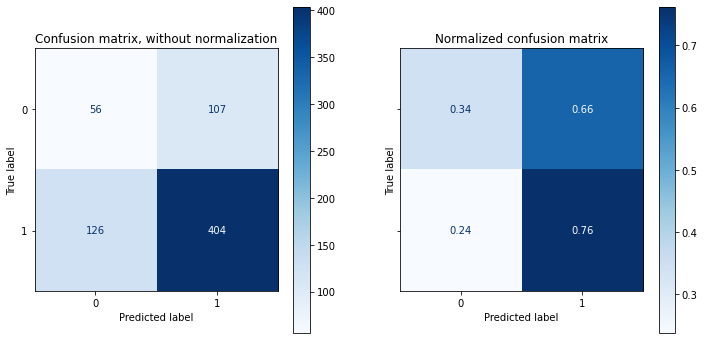

In [62]:
parameters = {
    'max_depth':[None] + [i for i in range(2,8)],
    'class_weight': [None, 'balanced'],
    'min_samples_split': [i for i in range(1, 41)],
    'min_samples_leaf': [i for i in range(1, 21)],
    'max_features': [None, 'auto']
    }
create_classifier(DecisionTreeClassifier(), parameters)

saved_models/GaussianNB-balanced_accuracy.lib
balanced_accuracy {}
	0.5653627632362453
saved_models/GaussianNB-f1.lib
f1 {}
	0.8464102980189327
saved_models/GaussianNB-average_precision.lib
average_precision {}
	0.8362506150854002
saved_models/GaussianNB-roc_auc.lib
roc_auc {}
	0.64011368498521
test_accuracy        	0.7444	0.06468935 
test_balanced_accuracy 	0.5884	0.07080457 
test_precision       	0.8022	0.02927920 
test_recall          	0.8829	0.06792778 
test_f1              	0.8399	0.04353058 
test_average_precision 	0.8206	0.05433516 
test_roc_auc         	0.6047	0.10308879 



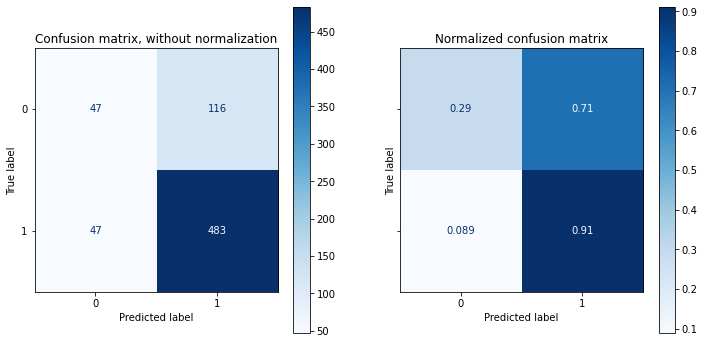

In [63]:
parameters = {}
clf = create_classifier(GaussianNB(), parameters)

saved_models/KNeighborsClassifier-balanced_accuracy.lib
balanced_accuracy {'leaf_size': 4, 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
	0.538356875216868
saved_models/KNeighborsClassifier-f1.lib
f1 {'leaf_size': 1, 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
	0.8689261226131031
saved_models/KNeighborsClassifier-average_precision.lib
average_precision {'leaf_size': 31, 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
	0.8073953515812673
saved_models/KNeighborsClassifier-roc_auc.lib
roc_auc {'leaf_size': 31, 'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}
	0.5913090612316185
test_accuracy        	0.7301	0.03889120 
test_balanced_accuracy 	0.5213	0.04853549 
test_precision       	0.7735	0.02002129 
test_recall          	0.9149	0.03749612 
test_f1              	0.8380	0.02515205 
test_average_precision 	0.7908	0.03588906 
test_roc_auc         	0.5595	0.09353608 



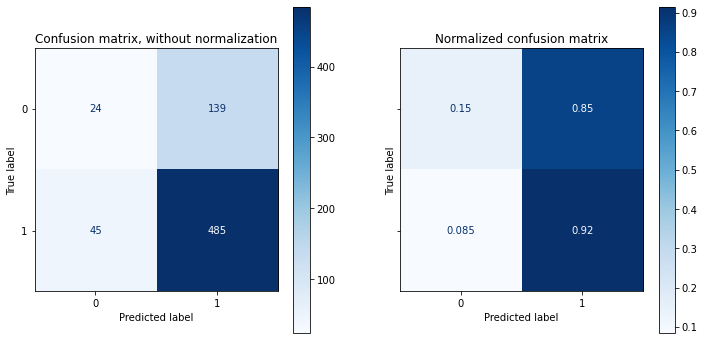

In [64]:
parameters = {
    'n_neighbors': [i for i in range(1, 31, 2)],
    'weights': ['uniform', 'distance'],
    'leaf_size': [i for i in range(1, 61, 3)],
    'p': [1, 2, 5],
    }
clf = create_classifier(KNeighborsClassifier(), parameters)

saved_models/LinearDiscriminantAnalysis-balanced_accuracy.lib
balanced_accuracy {'solver': 'svd'}
	0.527750376305691
saved_models/LinearDiscriminantAnalysis-f1.lib
f1 {'solver': 'svd'}
	0.8666318632442214
saved_models/LinearDiscriminantAnalysis-average_precision.lib
average_precision {'solver': 'svd'}
	0.8408441899983848
saved_models/LinearDiscriminantAnalysis-roc_auc.lib
roc_auc {'solver': 'svd'}
	0.646367903580808
test_accuracy        	0.7690	0.02858763 
test_balanced_accuracy 	0.5454	0.04452575 
test_precision       	0.7823	0.01822773 
test_recall          	0.9680	0.02767681 
test_f1              	0.8650	0.01672021 
test_average_precision 	0.8400	0.04877999 
test_roc_auc         	0.6273	0.10333512 



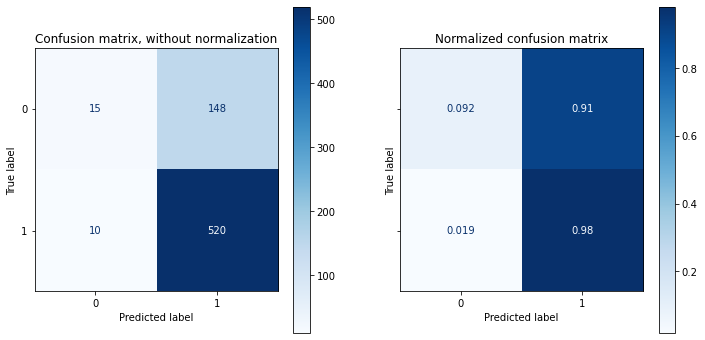

In [65]:
parameters = [
        {
            'solver': ['svd']
        },
        {
            'solver': ['lsqr', 'eigen'],
            'shrinkage': [None, 'auto']
        }
    ]
clf = create_classifier(LinearDiscriminantAnalysis(), parameters)

saved_models/LogisticRegression-balanced_accuracy.lib
balanced_accuracy {'C': 10, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l2', 'solver': 'lbfgs'}
	0.6064349472670354
saved_models/LogisticRegression-f1.lib
f1 {'C': 10, 'class_weight': None, 'max_iter': 300, 'penalty': 'l2', 'solver': 'newton-cg'}
	0.8681015493627066
saved_models/LogisticRegression-average_precision.lib
average_precision {'C': 50, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'sag'}
	0.8422277717747809
saved_models/LogisticRegression-roc_auc.lib
roc_auc {'C': 1, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
	0.6485070632359086
test_accuracy        	0.6018	0.07601629 
test_balanced_accuracy 	0.5642	0.08954369 
test_precision       	0.8041	0.05313438 
test_recall          	0.6339	0.08146843 
test_f1              	0.7067	0.06336686 
test_average_precision 	0.8393	0.04827843 
test_roc_auc         	0.6225	0.10556362 



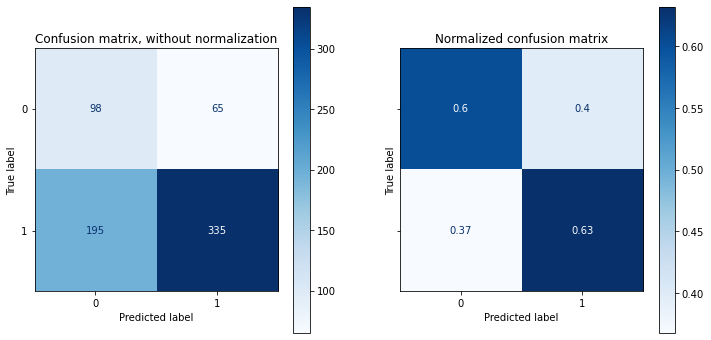

In [66]:
parameters = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10, 50, 100, 200, 500, 1000],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag'],
    'max_iter': [300, 500],
    'class_weight': [None, 'balanced']
    }

clf = create_classifier(LogisticRegression(), parameters)

saved_models/QuadraticDiscriminantAnalysis-balanced_accuracy.lib
balanced_accuracy {'reg_param': 0.001}
	0.5718702452272183
saved_models/QuadraticDiscriminantAnalysis-f1.lib
f1 {'reg_param': 0.1}
	0.8671209862948582
saved_models/QuadraticDiscriminantAnalysis-average_precision.lib
average_precision {'reg_param': 0.001}
	0.8299884195035022
saved_models/QuadraticDiscriminantAnalysis-roc_auc.lib
roc_auc {'reg_param': 0.001}
	0.6419675336634868
test_accuracy        	0.7603	0.04180692 
test_balanced_accuracy 	0.5885	0.06107627 
test_precision       	0.8017	0.02741741 
test_recall          	0.9132	0.03526574 
test_f1              	0.8535	0.02568510 
test_average_precision 	0.8230	0.05799175 
test_roc_auc         	0.6026	0.11392841 



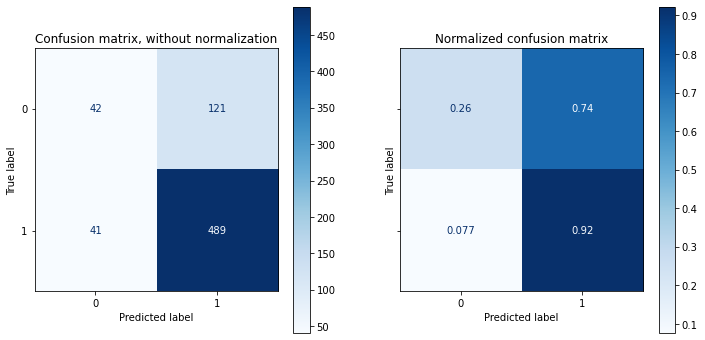

In [67]:
parameters = {
    'reg_param': [None, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    }

clf = create_classifier(QuadraticDiscriminantAnalysis(), parameters)

saved_models/SVC-balanced_accuracy.lib
balanced_accuracy {'C': 10, 'class_weight': None, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 500}
	0.560257226211897
saved_models/SVC-f1.lib
f1 {'C': 0.1, 'class_weight': None, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 500}
	0.8692876449381098
saved_models/SVC-average_precision.lib
average_precision {'C': 1, 'class_weight': None, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 500}
	0.8356262227146197
saved_models/SVC-roc_auc.lib
roc_auc {'C': 1, 'class_weight': None, 'degree': 3, 'gamma': 'auto', 'kernel': 'poly', 'max_iter': 500}
	0.6367667507895628
test_accuracy        	0.5858	0.09322938 
test_balanced_accuracy 	0.5176	0.10199606 
test_precision       	0.7738	0.05929040 
test_recall          	0.6447	0.10957681 
test_f1              	0.6997	0.08602724 
test_average_precision 	0.7949	0.06926261 
test_roc_auc         	0.5428	0.12157694 



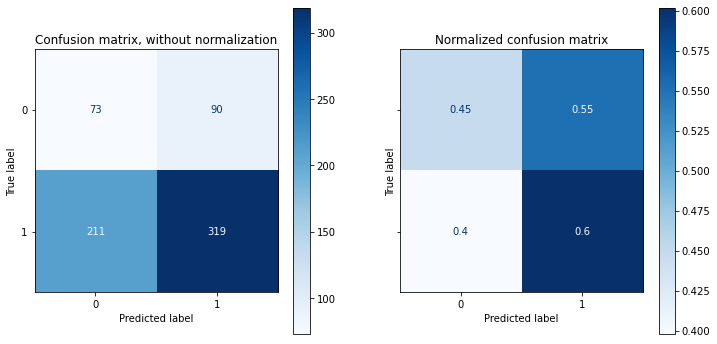

In [68]:
parameters = {
    'C': [0.1, 1, 10, 50, 100, 200, 500, 1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3],
    'class_weight': [None, 'balanced'],
    'max_iter': [500],
    'probability': True
    }

clf = create_classifier(SVC(), parameters)

# Model Comparison

In [69]:
for base_model, base_result, new_model, new_result in zip(base_models, base_results, new_models, new_results):
    print(f"{str(base_model):26}\t Mean\t\t Std")
    for (base_k, base_v), (new_k, new_v) in zip(base_result.items(), new_result.items()):
        print(f"{base_k:26}\t {(new_v.mean() - base_v.mean()):8.4f}\t {(new_v.std() - base_v.std()):8.4f}")
    print()

DecisionTreeClassifier()  	 Mean		 Std
fit_time                  	  -0.0392	  -0.0031
score_time                	  -0.0041	  -0.0016
test_accuracy             	  -0.0442	   0.0293
test_balanced_accuracy    	   0.0086	   0.0462
test_precision            	   0.0145	   0.0339
test_recall               	  -0.0924	   0.0593
test_f1                   	  -0.0488	   0.0323
test_average_precision    	   0.0091	   0.0168
test_roc_auc              	   0.0159	   0.0414

GaussianNB()              	 Mean		 Std
fit_time                  	  -0.0002	   0.0002
score_time                	   0.0011	   0.0014
test_accuracy             	  -0.0151	   0.0489
test_balanced_accuracy    	   0.0639	   0.0483
test_precision            	   0.0277	   0.0206
test_recall               	  -0.0845	   0.0534
test_f1                   	  -0.0204	   0.0341
test_average_precision    	  -0.0108	   0.0336
test_roc_auc              	  -0.0198	   0.0690

KNeighborsClassifier()    	 Mean		 Std
fit_time                  	  -0.004

# Ensemble

## Imports

In [74]:
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [71]:
pprint(new_models)

[DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       max_features='auto', min_samples_leaf=4,
                       min_samples_split=34),
 GaussianNB(),
 KNeighborsClassifier(leaf_size=4, n_neighbors=3, p=1),
 LinearDiscriminantAnalysis(),
 LogisticRegression(C=10, class_weight='balanced', max_iter=300),
 QuadraticDiscriminantAnalysis(reg_param=0.001),
 SVC(C=10, kernel='poly', max_iter=500)]


In [161]:
X_train, X_test, y_train, y_test = train_test_split(min_max_X, y, shuffle=True, stratify=y)

names = ['CART', 'GNB', 'KNN','LDA', 'LogR', 'QDA', 'SVC']
level0 = list(zip(names, new_models))

final = QuadraticDiscriminantAnalysis()

stacking_model = StackingClassifier(estimators=level0, final_estimator=final, cv=39, passthrough=False)

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

print(sklearn.metrics.roc_auc_score(y_test, y_pred_stack))
print(sklearn.metrics.balanced_accuracy_score(y_test, y_pred_stack))
print(sklearn.metrics.f1_score(y_test, y_pred_stack, average='weighted'))

0.5700949183933326
0.5700949183933326
0.7248353868244943


In [215]:
X_train, X_test, y_train, y_test = train_test_split(min_max_X, y, shuffle=True, stratify=y)

names = ['CART', 'GNB', 'KNN','LDA', 'LogR', 'QDA', 'SVC']
level0 = list(zip(names, new_models))

voting_model = VotingClassifier(estimators=level0, voting='soft')

voting_model.fit(X_train, y_train)
y_pred_vote = voting_model.predict(X_test)

print(sklearn.metrics.roc_auc_score(y_test, y_pred_vote))
print(sklearn.metrics.balanced_accuracy_score(y_test, y_pred_vote))
print(sklearn.metrics.f1_score(y_test, y_pred_vote, average='weighted'))

0.5649033452945943
0.5649033452945943
0.7211916012648389
